<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier. The paper we're replicating (the source of the dataset that we will be using) is available [here](https://arxiv.org/abs/1710). Reading through the forementioned paper, we see that the model architecture that they use to achieve their best results is available [here](https://arxiv.org/abs/162.05251).

If we want to find the ground truth for this notebook (with lots of diagrams and text annotations, [visit the github](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb))

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-edc1d4d0-08e2-9f6b-0b6f-d9174352e53e)


## Get data

Since we'll be replicating the paper above, which is 200k RCT (Randomized Controlled Trials), let's download the dataset they used. We can do so from the [author's Github](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign 
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we have some text data, it is time to become one with it. And one of the best ways to become one with the data is to visualize and visualize, lastly visualize. With that in mind, we'll write a function to read in all of the lines of a target text file.

In [ ]:
# Let's create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename (str): a string containing the target filepath.
  
  Returns:
    A list of strings with one string perl ine from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines.
train_lines = get_lines(data_dir+"train.txt")

In [ ]:
train_lines[:20]


['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...
```
[{"line_number": 0,
  "target": "BACKGROUND",
  "text": "Emotional eating is associated with overeating...",
  "total_lines": 11},
  ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its content and sorts through each line, 
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence 
  number the target line is
  """
  # Get all lines from filenames
  input_lines = get_lines(filename)

  # Create an empty abstract
  abstract_lines = ""

  # Create an empty list of abstracts
  abstract_samples = []

  # Loop through each line in the target file
  for line in input_lines:

    # Check if line is id line
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" # Reset abstract string if the line is an ID line
    elif line.isspace(): # Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract and keep count
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") 
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower() #
        line_data["line_number"] = abstract_line_number # what number line does the ine appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) -1 # How many lines are there in the target abstract (start with zero)
        abstract_samples.append(line_data) # add line data to abstrat samples list

    else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples
       

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")


CPU times: user 463 ms, sys: 83.6 ms, total: 547 ms
Wall time: 544 ms


In [ ]:
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [ ]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a dataframe to visualize it

In [ ]:
import pandas as pd

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


,target,text,line_number,total_lines
0,OBJECTIVE,"to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .",0,11
1,METHODS,a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .,1,11
2,METHODS,outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,2,11
3,METHODS,pain was assessed using the visual analog pain scale ( @-@ mm ) .,3,11
4,METHODS,"secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .",4,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

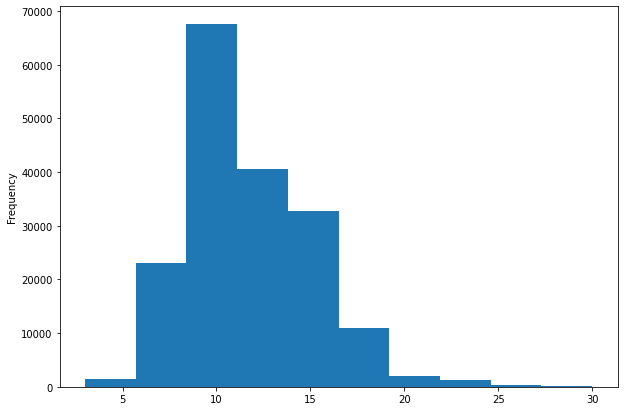

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(figsize=(10,7));

Get a list of sentences 

In [ ]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

## Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best. We will start with a baseline (tf-idf Multinomial Naive Bayes classifier)

</br>

### Experiments we are running

Experiment | Model
-----------|------
0 | Naives Bayes with TF-IDF encoder (baseline)
1 | Conv1D with token embeddings
2 | TensoFlow Hub pretrained feature extractor
3 | Conv1D with character embeddings
4 | Ptretrained token embeddings (same as 2) + character embeddings (same as 3)
5 | Ptretrained token embeddings + character embeddings + positional embeddings



## Model 0: Getting a Baseline

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score

0.7218323844829869

In [ ]:
# Make some predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In th previous module we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1), and rather than rewriting it here, we'll download it from our helper function script.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-02 13:15:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-02 13:15:00 (85.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
import numpy as np

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (text) for deep sequence models

Before we start building deeper models we've got to create vectorization and embedding layers.

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)


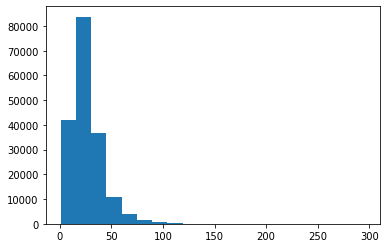

In [ ]:
# What does the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of the data
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our text from words to numbers.

In [ ]:
# How many words are in our vocab? (taken from table 2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

# We want to define our output sequence in function of the length of a sentence that comprises 95% of the data
max_length = output_seq_len

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import numpy as np


In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=max_length)

# Adapt text vectorizer to training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer([target_sentence])}")

Text:
we aimed to study the biological mechanisms underlying the observed non-specific and sex-differential effects of mv on mortality .

Length of text: 19

Vectorized text:[[   43   447     6    17     2  2568  1146  1727     2   148  3596     3
  34467    71     4  4151    18   259     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

> **Note -** Different embedding sizes result in drastically different numbers of parameters to train

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 we aimed to study the biological mechanisms underlying the observed non-specific and sex-differential effects of mv on mortality .

Sentence after vectorization (before embedding):
 [[   43   447     6    17     2  2568  1146  1727     2   148  3596     3
  34467    71     4  4151    18   259     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00062119 -0.03142854  0.02430857 ...  0.03305245 -0.02477524
   -0.01680168]
  [-0.03211762 -0.01709378 -0.01400031 ...  0.01988602 -0.02217555
   -0.00424279]
  [-0.01499524  0.04197704 -0.01639783 ... -0.02560095  0.02019832
    0.04539566]
  ...
  [-0.02504718 -0.03423636  0.03337474 ...  0.04061583 -0.04273217
   -0.01341403]
  [-0.02504718 -0.03423636  0.03337474 ...  0.04061583 -0.04273217
   -0.01341

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in:

* [Tensorflow data performance](https://www.tensorflow.org/guide/data_performance)
* [Tensorflow data guide](https://www.tensorflow.org/guide/data)

In [ ]:
# Turn our dataset into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_datast = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "SkimLit-logs"
num_classes

5

In [ ]:
# Create model_1
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, 5, activation="relu", padding="same", name="conv_1D_layer")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv_1D_layer (Conv1D)      (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)               

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              validation_data = valid_dataset,
                              epochs=3,
                              batch_size=32,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_1_tok_emb_conv1d")])

Saving TensorBoard log files to: SkimLit-logs/model_1_tok_emb_conv1d/20220902-131514
Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.9178 - accuracy: 0.6363 - val_loss: 0.6838 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6600 - accuracy: 0.7538 - val_loss: 0.6335 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6185 - accuracy: 0.7735 - val_loss: 0.5980 - val_accuracy: 0.7836


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6008 - accuracy: 0.7869


[0.6008138060569763, 0.7869058847427368]

In [ ]:
# Make predictions (our model predicts prediction probabilitiesfor each class)
model_1_pred_probs = model_1.predict(valid_dataset)


In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.69058652191183,
 'precision': 0.7843663132327271,
 'recall': 0.7869058652191182,
 'f1': 0.7846051747404235}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embedings from Tensorflow Hub, the Universal Sentence Encoder. The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer = hub.KerasLayer(model_url,
                                        trainable=False,
                                        input_shape=[],
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedding_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedding_sentence[0])}")

Random sentence:
 the ai group received daily step goals that adjusted up and down based on the percentile-rank algorithm and micro-incentives for goal attainment .
Sentence after embedding:
 [ 0.02303653 -0.08536497 -0.05828969  0.01210292  0.0144826   0.0095885
 -0.0707818   0.03393736 -0.04980762  0.06610805 -0.0549765   0.02647267
 -0.03450971 -0.01925569  0.03208711  0.05225488  0.01386639  0.03514696
 -0.0217395  -0.01991754 -0.05165051  0.07753915  0.02340977  0.01814729
  0.05881762 -0.03793885  0.01448446  0.03723347 -0.0474131   0.05763552]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub





In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: We could add more layers here if we wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs,outputs, name="model_2_USE_feature_extractor")

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9165 - accuracy: 0.6515 - val_loss: 0.7938 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7679 - accuracy: 0.7022 - val_loss: 0.7521 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7509 - accuracy: 0.7132 - val_loss: 0.7373 - val_accuracy: 0.7138


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7408 - accuracy: 0.7136


[0.7408214807510376, 0.7136237025260925]

In [ ]:
# Make some predictions with our feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3776235e-01, 3.6899605e-01, 2.2093256e-03, 1.8245685e-01,
        8.5753733e-03],
       [3.4539071e-01, 5.0932229e-01, 3.9731986e-03, 1.3806511e-01,
        3.2487193e-03],
       [2.6070839e-01, 1.2991656e-01, 1.5564041e-02, 5.5917025e-01,
        3.4640770e-02],
       ...,
       [1.9012148e-03, 6.0502882e-03, 5.4427002e-02, 7.1271730e-04,
        9.3690878e-01],
       [3.8661987e-03, 5.1953163e-02, 2.0950471e-01, 1.2304430e-03,
        7.3344547e-01],
       [1.7550883e-01, 2.4970061e-01, 5.1508301e-01, 7.9808049e-03,
        5.1726691e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on valid dataset
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.36237256719184,
 'precision': 0.7136590921996385,
 'recall': 0.7136237256719185,
 'f1': 0.7107339922132457}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character embeddings. Previously we've made token-level embeddings but we'll need to do similar steps for characters if we want to do char-level embeddings 

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# TExt splitting non-character'level sequence into characters

split_chars(random_train_sentence)

't h e   a i   g r o u p   r e c e i v e d   d a i l y   s t e p   g o a l s   t h a t   a d j u s t e d   u p   a n d   d o w n   b a s e d   o n   t h e   p e r c e n t i l e - r a n k   a l g o r i t h m   a n d   m i c r o - i n c e n t i v e s   f o r   g o a l   a t t a i n m e n t   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

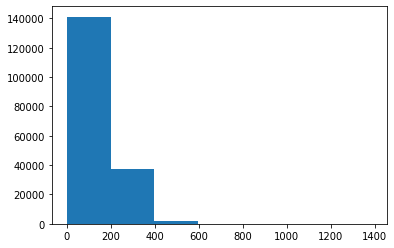

In [ ]:
# Check the distribution of our sequences at a character-level
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = (int(np.percentile(char_lens, 95)))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters 
random.choice(train_sentences)

'the aim was to evaluate its performance during laparoscopic cholecystectomy .'

In [ ]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV token (OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: k


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 c l i n i c a l t r i a l s . g o v   ,   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   .

Length of random_train_chars: 59

Vectorized chars:
 [[11 12  4  6  4 11  5 12  3  8  4  5 12  9 18  7 21  6 11  3  6 11  3  6
  11  3  6 11  3  6 11  3  6 11  3  6 11  3  6 11  3  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
len(char_vocab)

28

In [ ]:
# Create a char embeding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # this is the size of the char embedding in the paper:
                              mask_zero=True, 
                              name="char_embedding")

In [ ]:
# Test our character embedding layer
print(f"Charified texst:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified texst:
 c l i n i c a l t r i a l s . g o v   ,   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   ;   n c t @   .
Embedded chars. (after vectorization and embedding):
 [[[-0.03803312  0.03882346 -0.0309255  ... -0.02390729  0.02881566
    0.0491905 ]
  [ 0.03690653 -0.01608701 -0.01214997 ... -0.03509353  0.0453738
   -0.0091254 ]
  [-0.01060832 -0.01158019  0.01814665 ...  0.01194454 -0.04647348
   -0.00762177]
  ...
  [-0.04575245 -0.00368442 -0.02101606 ... -0.0438573   0.02338176
   -0.02853804]
  [-0.04575245 -0.00368442 -0.02101606 ... -0.0438573   0.02338176
   -0.02853804]
  [-0.04575245 -0.00368442 -0.02101606 ... -0.0438573   0.02338176
   -0.02853804]]]
Character embedding shape: (1, 290, 25)


## Create char dataset with tf.data API

In [ ]:
# Turn our dataset into TensorFlow Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Create a Conv1D model with character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=[], dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=20, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs,outputs, name="model_3_conv1d_char_embeddings")

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           32064     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
history_model_3 = model_3.fit(train_char_dataset,
                              validation_data=val_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_steps=int(0.1*len(val_char_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.1835 - accuracy: 0.5256 - val_loss: 0.9573 - val_accuracy: 0.6267
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9161 - accuracy: 0.6435 - val_loss: 0.8507 - val_accuracy: 0.6762
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.8394 - accuracy: 0.6756 - val_loss: 0.7856 - val_accuracy: 0.7015


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:5]

array([[0.19937463, 0.38348064, 0.1170837 , 0.2675336 , 0.03252748],
       [0.26330203, 0.20027353, 0.02252614, 0.47684583, 0.03705245],
       [0.06094655, 0.06388528, 0.00698838, 0.85409033, 0.01408948],
       [0.00679497, 0.00447885, 0.9606479 , 0.00768648, 0.02039183],
       [0.04786706, 0.04801342, 0.72346514, 0.04081242, 0.13984194]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 3, 3, 2, 2, 4, 2, 4, 4, 1])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 69.29696809214882,
 'precision': 0.689477772845138,
 'recall': 0.6929696809214881,
 'f1': 0.6852590511672155}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
{'accuracy': 68.37349397590361,
 'precision': 0.68323019230491,
 'recall': 0.6837349397590361,
 'f1': 0.6739334110383196}

{'accuracy': 68.37349397590361,
 'precision': 0.68323019230491,
 'recall': 0.6837349397590361,
 'f1': 0.6739334110383196}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embeding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a char-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of our [reference paper](https://arxiv.org/pdf/1612.05251.pdf).
5. Construct a model which takes token and character-level sequence as inputs and produces sequence label probabilities as output.




In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, 
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Fig. 1
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create a hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in ection 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(256, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

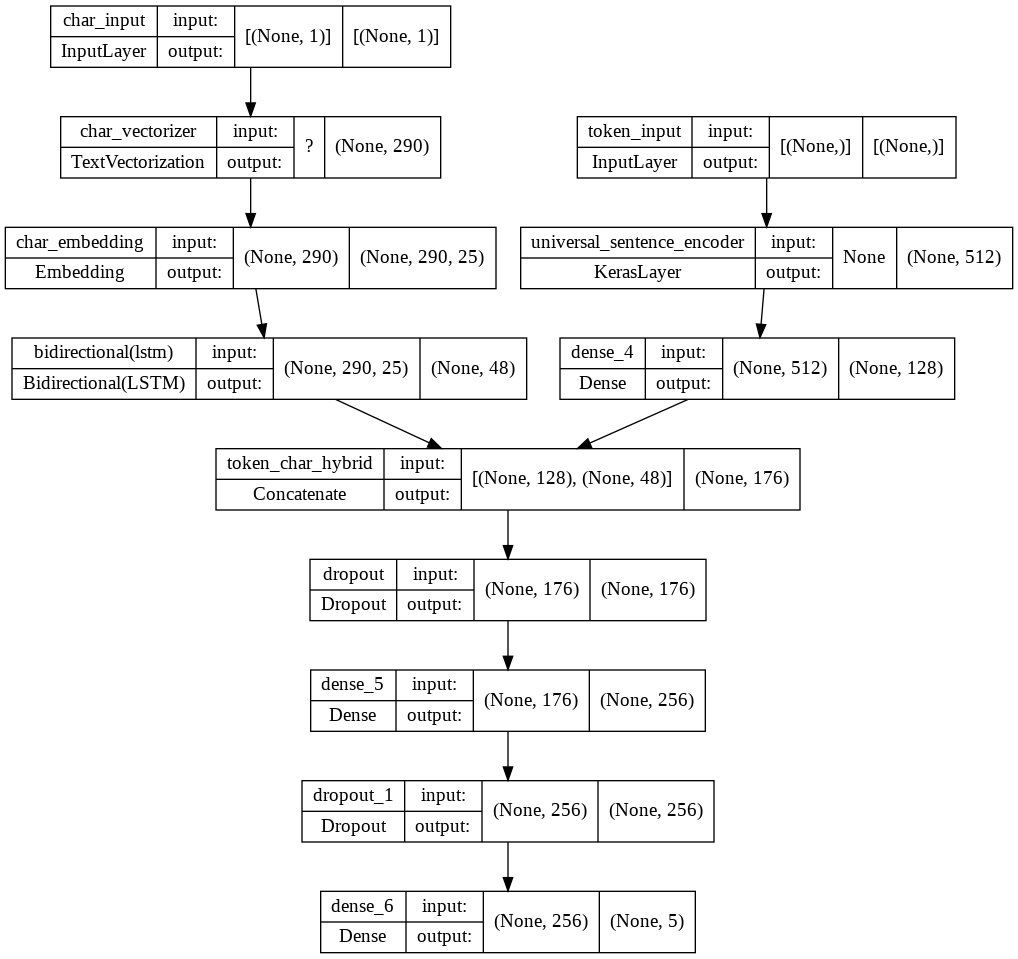

In [ ]:
# Plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # In the paper they use SGD, and we're using Adam.
                metrics=["accuracy"])

## Combining token and character data into a tf.data Dataset


### Train dataset

In [ ]:
# Combining token and character data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
len(train_char_token_dataset)

5627

### Validation dataset

In [ ]:
# combine token and character data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
len(val_char_token_dataset)

945

### Test dataset 

In [ ]:
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

# Batch and prefetch our test data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Fitting a model with combined token and character level sequences

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)),
                              epochs=3)

Epoch 1/3
562/562 [==============================] - 34s 45ms/step - loss: 0.9512 - accuracy: 0.6262 - val_loss: 0.7615 - val_accuracy: 0.7098
Epoch 2/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7869 - accuracy: 0.6940 - val_loss: 0.7036 - val_accuracy: 0.7324
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7593 - accuracy: 0.7084 - val_loss: 0.6827 - val_accuracy: 0.7460


In [ ]:
# Evaluate on the whole evaluation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6896 - accuracy: 0.7370


[0.6896342635154724, 0.7369919419288635]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

In [ ]:
model_4_pred_probs[:10]

array([[4.2936826e-01, 3.3298129e-01, 2.9611436e-03, 2.2876222e-01,
        5.9271096e-03],
       [3.4939456e-01, 4.6789208e-01, 3.0700509e-03, 1.7828730e-01,
        1.3559418e-03],
       [3.0899379e-01, 1.0144826e-01, 3.9837305e-02, 5.2375150e-01,
        2.5969174e-02],
       [9.4371745e-03, 1.3455543e-02, 8.7598819e-01, 6.2673995e-03,
        9.4851762e-02],
       [1.9563761e-02, 6.7136079e-02, 6.3997549e-01, 1.5311783e-02,
        2.5801292e-01],
       [8.7515998e-04, 2.3118078e-03, 6.7925203e-01, 4.5886624e-04,
        3.1710219e-01],
       [3.8059289e-03, 1.0681167e-02, 5.6201440e-01, 2.1320260e-03,
        4.2136642e-01],
       [2.6694362e-03, 1.9347822e-02, 4.9296159e-01, 9.2625001e-04,
        4.8409489e-01],
       [3.2163953e-04, 8.3262185e-03, 2.9055772e-02, 2.7839671e-04,
        9.6201795e-01],
       [2.7345607e-01, 4.7261548e-01, 3.9846484e-02, 1.4525549e-01,
        6.8826459e-02]], dtype=float32)

In [ ]:
# Format pred_probs into pred_labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 2, 4, 1])>

In [ ]:
# Get results on token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.69919237389117,
 'precision': 0.7371155155926274,
 'recall': 0.7369919237389116,
 'f1': 0.7353071076514588}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embedding 

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,"to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .",0,11
1,METHODS,a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .,1,11
2,METHODS,outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,2,11
3,METHODS,pain was assessed using the visual analog pain scale ( @-@ mm ) .,3,11
4,METHODS,"secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .",4,11


In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

To use the line numbers as a positional embedding layer, we first need to do a one-hot encode. Now, we have 30 possible values in this column, and one-hot encoding all 30 values would be counterproducent. 

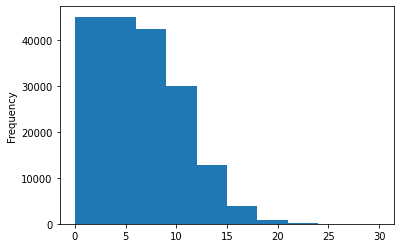

In [ ]:
train_df.line_number.plot.hist();

So cutting our one-hot to 15 lines puts the majority of the data into line numbers

In [ ]:
line_number_depth = int(np.percentile(train_df.line_number, 95))

In [ ]:
# Use tensorflow to create one-hot-encoded tensors of our line numbers
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth=line_number_depth)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth=line_number_depth)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth=line_number_depth)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 13), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 13]))

Now we've encoded our line number features, we'll encode the total lines features 

In [ ]:
# Check out total_lines 

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,"to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .",0,11
1,METHODS,a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .,1,11
2,METHODS,outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,2,11
3,METHODS,pain was assessed using the visual analog pain scale ( @-@ mm ) .,3,11
4,METHODS,"secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .",4,11


In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

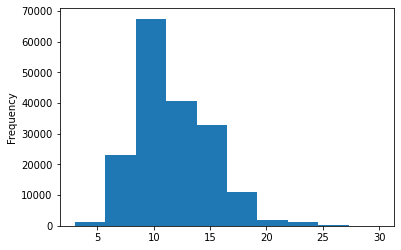

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
total_lines_depth = int(np.percentile(train_df.total_lines, 95))

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=total_lines_depth)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=total_lines_depth)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=total_lines_depth)

In [ ]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 18]), <tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=float

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 and 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities.
8. Combine inputs of 1, 2, 3, 4, and outputs of into a `tf.keras.Model`

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Character level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(line_number_depth,), 
                                  dtype=tf.float32, 
                                  name="line_number_inputs")

x = layers.Dense(32, activation="relu")(line_number_inputs)

# Combine inputs and dense layer into a model
line_numbers_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)


# 4. total lines model
total_lines_inputs = layers.Input(shape=(total_lines_depth,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine line_numbers_model and total_line_model
tribrid_embeddings = layers.Concatenate(name="token_char_positional_concat")([line_numbers_model.output,
                                                                              total_lines_model.output,
                                                                              z])

# 7. Create an output layer to accept the tribried embedding and output label probabilities.
output_layer = layers.Dense(5, activation="softmax")(tribrid_embeddings)

# 8. Combine inputs of 1, 2, 3, 4, and outputs of into a `tf.keras.Model`
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input,
                                 line_numbers_model.input,
                                 total_lines_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")



model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

In [ ]:
# Label smoothing helps to prevent overfitting 
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

>**What is label smoothing -** For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes. Consider a eally confident prediction probability `[0.0, 0.0, 1.0, 0.0, 0.0]`. What label smoothing does is it assigns some of the value from the highest pred prob ot other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.01, 0.96, 0.01, 0.01]`

For more on label smoothing, [see this blog post from PyImageSearch](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/)

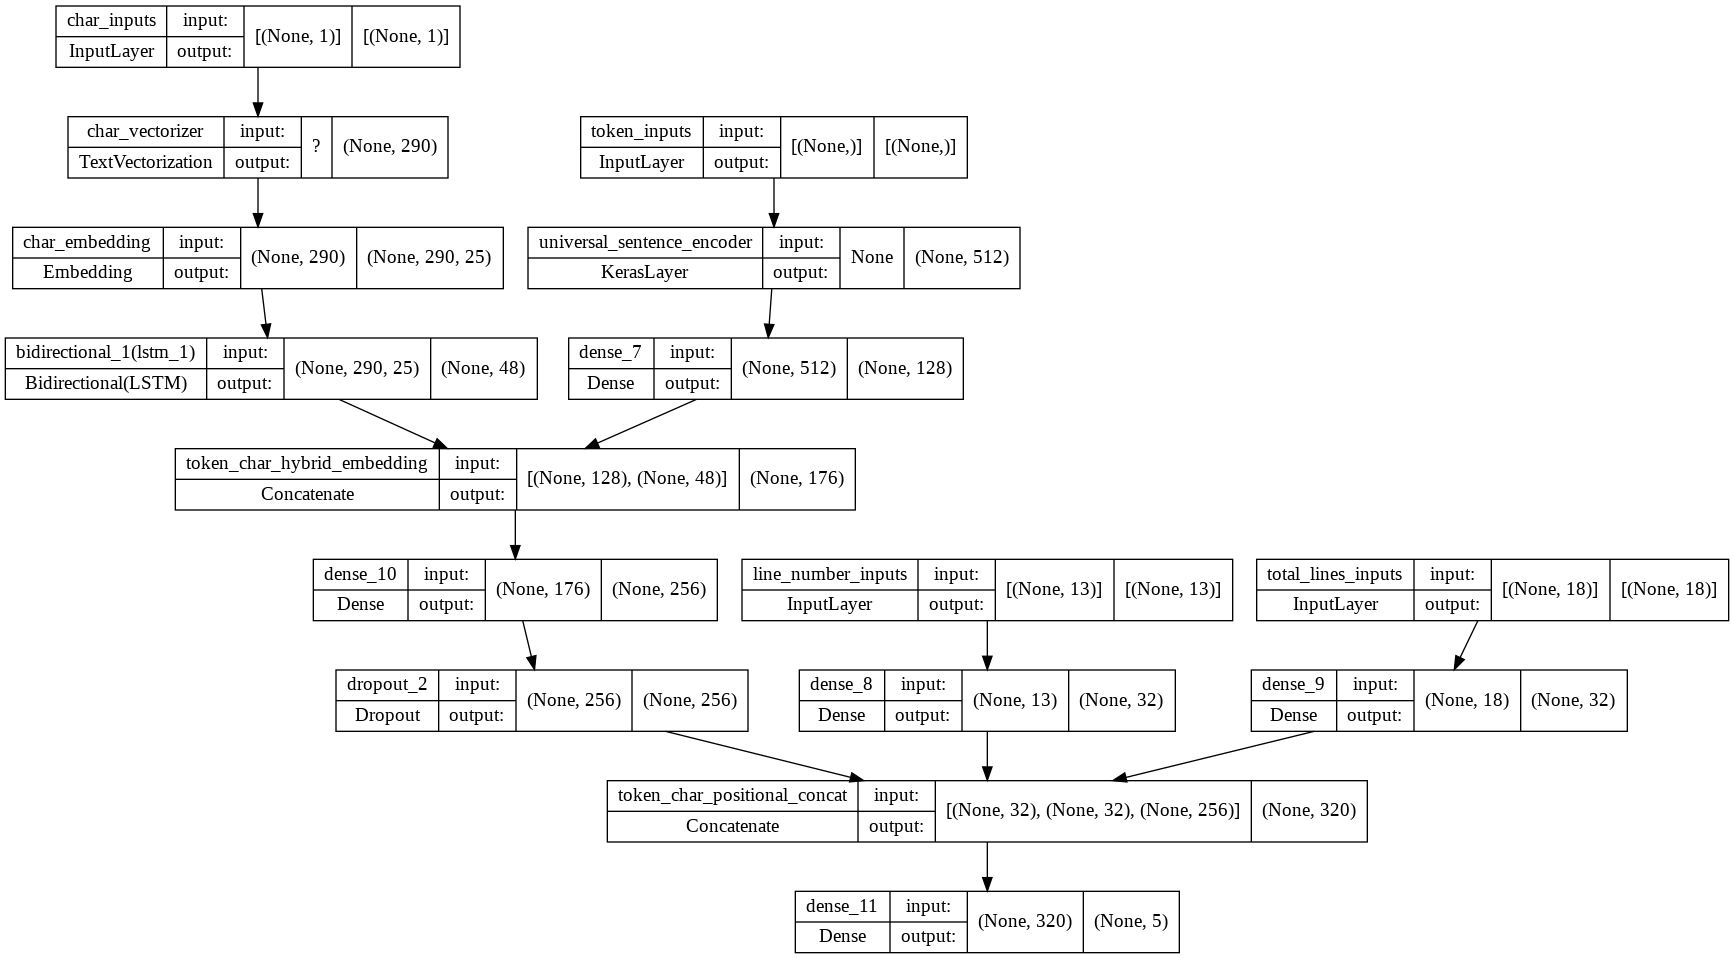

In [ ]:
plot_model(model_5, show_shapes=True)

## Create performant data pipeline for model 5.
Like we did on model 4, now we need to integrate two more inputs and outputs to our model.

Repeat this process for train, validation and test data:

1. Create dataset from tensor slices (use tuple of all input data as argument).
2. Create label dataset and use tuples of all input labels as argument
3. zip dataset and labels.



In [ ]:
# combine token and character data:

# Train data
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars,
                                                         train_line_numbers_one_hot,
                                                         train_total_lines_one_hot))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation data
val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars,
                                                       val_line_numbers_one_hot,
                                                       val_total_lines_one_hot))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Check input shapes
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 46ms/step - loss: 1.0918 - accuracy: 0.7290 - val_loss: 0.9823 - val_accuracy: 0.8015
Epoch 2/3
562/562 [==============================] - 23s 40ms/step - loss: 0.9683 - accuracy: 0.8160 - val_loss: 0.9505 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9506 - accuracy: 0.8205 - val_loss: 0.9366 - val_accuracy: 0.8334


In [ ]:
# Evaluate model
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.9352 - accuracy: 0.8324


[0.9351701140403748, 0.832384467124939]

In [ ]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate model_5 results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.23844829868926,
 'precision': 0.8310299931857428,
 'recall': 0.8323844829868926,
 'f1': 0.831219539748062}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_4_results

{'accuracy': 73.69919237389117,
 'precision': 0.7371155155926274,
 'recall': 0.7369919237389116,
 'f1': 0.7353071076514588}

In [ ]:
## Compare all our different model results
all_model_results = pd.DataFrame({"model_0_baseline" :baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose().sort_values(by="f1", ascending=False)
all_model_results["accuracy"] = all_model_results.accuracy/100
all_model_results

,accuracy,precision,recall,f1
model_5_pos_char_token_embedding,0.832384,0.831030,0.832384,0.831220
model_1_custom_token_embedding,0.786906,0.784366,0.786906,0.784605
model_4_hybrid_char_token_embedding,0.736992,0.737116,0.736992,0.735307
model_2_pretrained_token_embedding,0.713624,0.713659,0.713624,0.710734
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_3_char_embedding,0.692970,0.689478,0.692970,0.685259


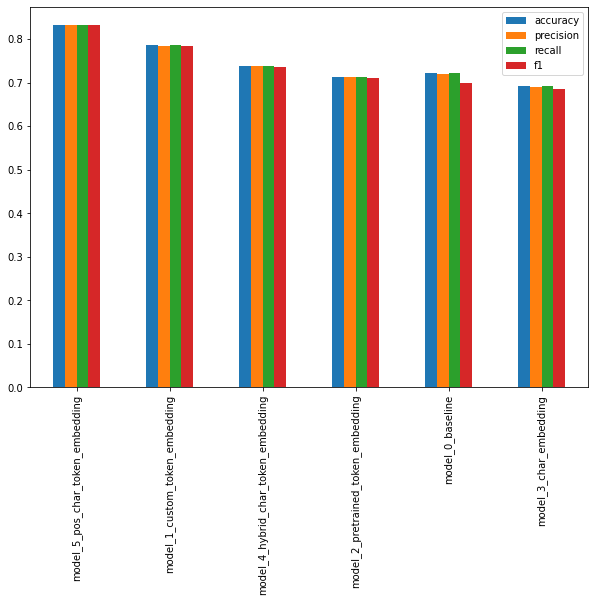

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

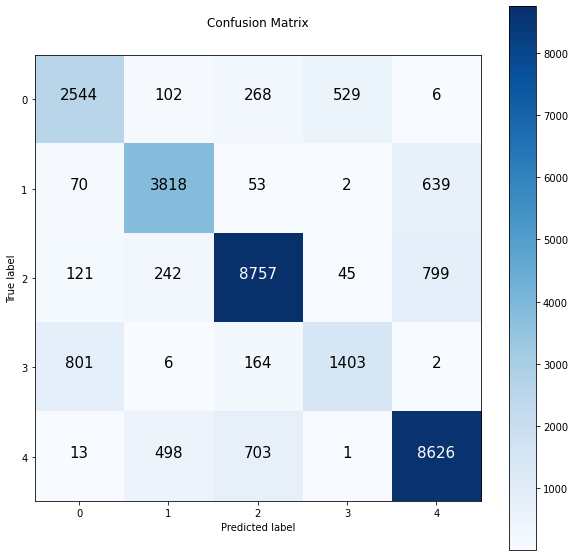

In [ ]:
from helper_functions import make_confusion_matrix

class_names = np.concatenate([y for x, y in val_tribrid_dataset],axis=0)
make_confusion_matrix(y_true=val_labels_encoded,
                      y_pred=model_5_preds,
                      classes=class_names.all())

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:

loaded_model.evaluate(val_tribrid_dataset)

945/945 [==============================] - 21s 19ms/step - loss: 0.9352 - accuracy: 0.8324


[0.9351701140403748, 0.832384467124939]

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_tribrid_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.23844829868926,
 'precision': 0.8310299931857428,
 'recall': 0.8323844829868926,
 'f1': 0.831219539748062}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
## Download and load in a pretrined model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mdir skimlit_gs_model
!unzip skimlit_tribrid_ymodel.zip -d skimlit_gs_model


--2022-09-02 13:22:42--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M   109MB/s    in 9.2s    

2022-09-02 13:22:51 (99.3 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

/bin/bash: mdir: command not found
unzip:  cannot find or open skimlit_tribrid_ymodel.zip, skimlit_tribrid_ymodel.zip.zip or skimlit_tribrid_ymodel.zip.ZIP.


In [ ]:
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

# Challenges:

1. Turn the test data samples into a tf.data Dataset (fast loading) and evaluate the best performing model on the test samples.

2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong labels with the highest prediction probability).

3. Make example predictions (on RCT abstracts from the wild). Go on to [PubMed](https://pubmed.ncbi.nlm.nih.gov/), find and use our model to predict on 3-4 different abstracts from the wild.
  * [Some examples](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json).

4. See the exercises and extra curriculum section on GitHub to further test skills (for section 09)

### 1. Turn test data samples into a `tf.data` dataset.

In [ ]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .,0,8
1,RESULTS,a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .,1,8
2,RESULTS,"liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .",2,8
3,RESULTS,"survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .",3,8
4,RESULTS,the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .,4,8


For test data samples, I need (1) to set up the dataset object with the four following:

* `test_sentences`
* `test_chars`
* `test_line_numbers_one_hot`
* `test_total_lines_one_hot`

Then, (2) set up the label as a tf.data.Dataset object

* `test_labels_one_hot`

Afterwards, (3) create a dataset with zipped (1) and (2) into a single dataset.

Finally (4) make the dataset loader performant, with batching and `tf.data.AUTOTUNE`.

In [ ]:
# 1. Set data without labels as tf.data.Dataset object
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, 
                                                        test_line_numbers_one_hot, 
                                                        test_total_lines_one_hot))

# 2. Set labels as tf.data.Dataset object
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

# 3. Zip data and labels into single dataset. This makes tuples inside the single dataset, which is taken by the model.
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

# 4. Make dataset performant
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5.evaluate(test_tribrid_dataset)

942/942 [==============================] - 18s 20ms/step - loss: 0.9440 - accuracy: 0.8284


[0.9440087676048279, 0.8284386992454529]

In [ ]:
test_model_5_pred_probs = model_5.predict(test_tribrid_dataset)

In [ ]:
test_data_model_5_preds = tf.argmax(test_model_5_pred_probs, axis=1)

In [ ]:
test_data_model_5_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_data_model_5_preds)
test_data_model_5_results

{'accuracy': 82.84386925501907,
 'precision': 0.826733039610497,
 'recall': 0.8284386925501908,
 'f1': 0.8271907956056315}

In [ ]:
model_5_results

{'accuracy': 83.23844829868926,
 'precision': 0.8310299931857428,
 'recall': 0.8323844829868926,
 'f1': 0.831219539748062}

In [ ]:
## Compare all our different model results
all_model_results = pd.DataFrame({"model_0_baseline" :baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results,
                                  "test_data_model_5":test_data_model_5_results})

all_model_results = all_model_results.transpose().sort_values(by="f1", ascending=False)
all_model_results["accuracy"] = all_model_results.accuracy/100
all_model_results


,accuracy,precision,recall,f1
model_5_pos_char_token_embedding,0.832384,0.831030,0.832384,0.831220
test_data_model_5,0.828439,0.826733,0.828439,0.827191
model_1_custom_token_embedding,0.786906,0.784366,0.786906,0.784605
model_4_hybrid_char_token_embedding,0.736992,0.737116,0.736992,0.735307
model_2_pretrained_token_embedding,0.713624,0.713659,0.713624,0.710734
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_3_char_embedding,0.692970,0.689478,0.692970,0.685259


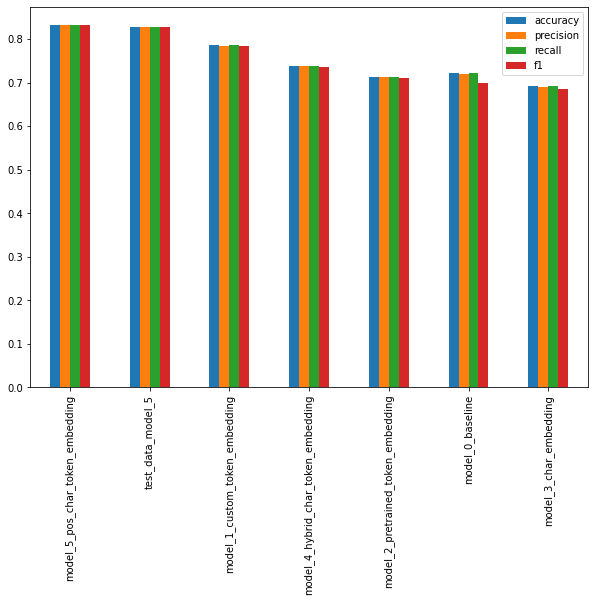

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
test_data_model_5_pred_probs = tf.reduce_max(test_model_5_pred_probs,axis=1)
test_data_model_5_pred_probs.numpy()

array([0.5203149, 0.37002  , 0.7980109, ..., 0.706204 , 0.7452937,
       0.6617912], dtype=float32)

Background = 0
Objectives = 1
Methods = 2
Results = 3
Conclusion = 4

In [ ]:
test_eval_df = pd.DataFrame({"text": test_df.text.to_numpy(),
                             "target": test_df.target.to_numpy(),
                             "target_encoded": test_labels_encoded,
                             "pred": test_data_model_5_preds,
                             "pred_prob": tf.reduce_max(test_model_5_pred_probs, axis=1)})

test_eval_df = test_eval_df
test_eval_df.head(10)

,text,target,target_encoded,pred,pred_prob
0,this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .,BACKGROUND,0,3,0.520315
1,a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .,RESULTS,4,3,0.370020
2,"liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .",RESULTS,4,2,0.798011
3,"survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .",RESULTS,4,2,0.670548
4,the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .,RESULTS,4,4,0.756002
5,"when mean hemodynamic profiles were compared in patients with abnormal versus normal lfts , elevated total bilirubin was associated with a significantly lower cardiac index ( @ vs @ ; p < @ ) and higher central venous pressure ( @ vs @ ; p = @ ) .",RESULTS,4,4,0.896541
6,"multivariable analyses revealed that patients with elevated meld-xi scores ( @ ) had a @-fold ( hazard ratio@ @ , @ % confidence interval @-@ @ ) increased risk of death , rehospitalization , or transplantation after adjusting for baseline lfts , age , sex , race , body mass index , diabetes , and systolic blood pressure .",RESULTS,4,4,0.519146
7,abnormal lfts are common in the adhf population and are a dynamic marker of an impaired hemodynamic state .,CONCLUSIONS,1,1,0.464296
8,elevated meld-xi scores are associated with poor outcomes among patients admitted with adhf .,CONCLUSIONS,1,4,0.492077
9,minimally invasive endovascular aneurysm repair ( evar ) could be a surgical technique that improves outcome of patients with ruptured abdominal aortic aneurysm ( raaa ) .,BACKGROUND,0,0,0.571553


In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

most_wrong = test_eval_df[test_eval_df["target_encoded"] != test_eval_df["pred"]].sort_values(by="pred_prob", ascending=False)
most_wrong.tail()

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


,text,target,target_encoded,pred,pred_prob
19439,it also looks at whether ` feedback-informed treatment ' affects the quality of the alliance .,BACKGROUND,0,2,0.242828
1319,the authors identified @ patients ( @ % of the sample ) who might benefit from changes in their psychotropic prescriptions .,RESULTS,4,3,0.240763
24332,"we hypothesized that increased hypoxic chemosensitivity in men could be associated with the development of nocturnal periodic breathing at altitude more frequently than in women , and that acetazolamide , by leftward shifting the co@ ventilatory response , could improve nocturnal periodic breathing at altitude in a sex-independent manner .",OBJECTIVE,3,0,0.239042
23020,"overall , there were improvements in risk factor recording and in prescribing of recommended treatments among under-treated individuals , but it is unclear how this intervention was used in practice and what factors promoted or hindered its use .",BACKGROUND,0,1,0.235849
23023,"our aims are to understand how , why , and for whom the intervention produced the observed outcomes and to develop effective strategies for translation and dissemination .",BACKGROUND,0,2,0.234473


### 4. Test data in the wild





In [ ]:
abstract = ''' Cannabidiol (CBD) and Δ9-tetrahydrocannabinol (THC) are the most represented phytocannabinoids in Cannabis sativa plants. 
However, CBD may present with a different activity compared with the psychotomimetic THC. 
Most typically, CBD is reported to be used in some medical conditions, including chronic pain. 
Conversely, the main aim of this systematic review is to assess and summarise the available body of evidence relating to both efficacy and safety of CBD as a treatment for psychiatric disorders, alone and/or in combination with other treatments. 
Eligible studies included randomized controlled trials (RCT) assessing the effect of CBD in a range of psychopathological conditions, 
such as substance use; psychosis, anxiety, mood disturbances, and other psychiatric (e.g., cognitive impairment; sleep; personality; eating; obsessive-compulsive; post-traumatic stress/PTSD; dissociative; and somatic) disorders. 
For data gathering purposes, the PRISMA guidelines were followed. 
The initial search strategy identified some n = 1301 papers; n = 190 studies were included after the abstract's screening and n = 27 articles met the inclusion criteria. 
There is currently limited evidence regarding the safety and efficacy of CBD for the treatment of psychiatric disorders. 
However, available trials reported potential therapeutic effects for specific psychopathological conditions, such as substance use disorders, chronic psychosis, and anxiety. 
Further large-scale RCTs are required to better evaluate the efficacy of CBD in both acute and chronic illnesses, special categories, as well as to exclude any possible abuse liability.
'''

sentences = abstract.split(".")
total_lines = len(sentences)

chars = [split_chars(sentence) for sentence in sentences]
total_lines = [total_lines for sentence in sentences]
total_lines = np.array(total_lines)

line_numbers = [i for i, sentence in enumerate(sentences)]
line_numbers = np.array(line_numbers)


In [ ]:
total_lines.shape

(13,)

In [ ]:
# Create one-hot encoding for line number
line_numbers_one_hot = tf.one_hot(line_numbers, depth=line_number_depth)
total_lines_one_hot = tf.one_hot(total_lines, depth=total_lines_depth)

line_numbers_one_hot


<tf.Tensor: shape=(13, 13), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)>

In [ ]:
abstract_data = tf.data.Dataset.from_tensor_slices((sentences, chars, line_numbers_one_hot, total_lines_one_hot))

abstract_data = abstract_data.batch(32)

In [ ]:
val_tribrid_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
abstract_dataset = tf.data.Dataset.zip((abstract_data, ))

In [ ]:
abstract_pred_probs = model_5.predict(abstract_dataset)
abstract_preds = tf.argmax(abstract_pred_probs, axis=1)
abstract_preds

<tf.Tensor: shape=(13,), dtype=int64, numpy=array([0, 0, 0, 0, 2, 2, 2, 2, 4, 1, 1, 1, 0])>

In [ ]:
abstract

" Cannabidiol (CBD) and Δ9-tetrahydrocannabinol (THC) are the most represented phytocannabinoids in Cannabis sativa plants. \nHowever, CBD may present with a different activity compared with the psychotomimetic THC. \nMost typically, CBD is reported to be used in some medical conditions, including chronic pain. \nConversely, the main aim of this systematic review is to assess and summarise the available body of evidence relating to both efficacy and safety of CBD as a treatment for psychiatric disorders, alone and/or in combination with other treatments. \nEligible studies included randomized controlled trials (RCT) assessing the effect of CBD in a range of psychopathological conditions, \nsuch as substance use; psychosis, anxiety, mood disturbances, and other psychiatric (e.g., cognitive impairment; sleep; personality; eating; obsessive-compulsive; post-traumatic stress/PTSD; dissociative; and somatic) disorders. \nFor data gathering purposes, the PRISMA guidelines were followed. \nTh

In [ ]:
abstract_df = pd.DataFrame({"sentence": sentences,
                            "pred":abstract_preds,
                            "pred_prob": tf.reduce_max(abstract_pred_probs, axis=1)})

abstract_df

,sentence,pred,pred_prob
0,Cannabidiol (CBD) and Δ9-tetrahydrocannabinol (THC) are the most represented phytocannabinoids in Cannabis sativa plants,0,0.725645
1,"\nHowever, CBD may present with a different activity compared with the psychotomimetic THC",0,0.603842
2,"\nMost typically, CBD is reported to be used in some medical conditions, including chronic pain",0,0.600355
3,"\nConversely, the main aim of this systematic review is to assess and summarise the available body of evidence relating to both efficacy and safety of CBD as a treatment for psychiatric disorders, alone and/or in combination with other treatments",0,0.451259
4,"\nEligible studies included randomized controlled trials (RCT) assessing the effect of CBD in a range of psychopathological conditions, \nsuch as substance use; psychosis, anxiety, mood disturbances, and other psychiatric (e",2,0.744478
5,g,2,0.784368
6,", cognitive impairment; sleep; personality; eating; obsessive-compulsive; post-traumatic stress/PTSD; dissociative; and somatic) disorders",2,0.575888
7,"\nFor data gathering purposes, the PRISMA guidelines were followed",2,0.567154
8,\nThe initial search strategy identified some n = 1301 papers; n = 190 studies were included after the abstract's screening and n = 27 articles met the inclusion criteria,4,0.526399
9,\nThere is currently limited evidence regarding the safety and efficacy of CBD for the treatment of psychiatric disorders,1,0.718243


In [ ]:
abstract_2 = """ Parkinson’s disease (PD) is a chronic neurodegenerative disorder characterized by motor symptoms such as bradykinesia, rest tremor, postural disturbances, and rigidity. PD is also characterized by non-motor symptoms such as sleep disturbances, cognitive deficits, and psychiatric disorders such as psychosis, depression, and anxiety. The pharmacological treatment for these symptoms is limited in efficacy and induce significant adverse reactions, highlighting the need for better treatment options. Cannabidiol (CBD) is a phytocannabinoid devoid of the euphoriant and cognitive effects of tetrahydrocannabinol, and preclinical and preliminary clinical studies suggest that this compound has therapeutic effect in non-motor symptoms of PD. In the present text, we review the clinical studies of cannabinoids in PD and the preclinical and clinical studies specifically on CBD. We found four randomized controlled trials (RCTs) involving the administration of agonists/antagonists of the cannabinoid 1 receptor, showing that these compounds were well tolerated, but only one study found positive results (reductions on levodopa-induced dyskinesia). We found seven preclinical models of PD using CBD, with six studies showing a neuroprotective effect of CBD. We found three trials involving CBD and PD: an open-label study, a case series, and an RCT. CBD was well tolerated, and all three studies reported significant therapeutic effects in non-motor symptoms (psychosis, rapid eye movement sleep behaviour disorder, daily activities, and stigma). However, sample sizes were small and CBD treatment was short (up to 6 weeks). Large-scale RCTs are needed to try to replicate these results and to assess the long-term safety of CBD."""

In [ ]:
abstract_2

' Parkinson’s disease (PD) is a chronic neurodegenerative disorder characterized by motor symptoms such as bradykinesia, rest tremor, postural disturbances, and rigidity. PD is also characterized by non-motor symptoms such as sleep disturbances, cognitive deficits, and psychiatric disorders such as psychosis, depression, and anxiety. The pharmacological treatment for these symptoms is limited in efficacy and induce significant adverse reactions, highlighting the need for better treatment options. Cannabidiol (CBD) is a phytocannabinoid devoid of the euphoriant and cognitive effects of tetrahydrocannabinol, and preclinical and preliminary clinical studies suggest that this compound has therapeutic effect in non-motor symptoms of PD. In the present text, we review the clinical studies of cannabinoids in PD and the preclinical and clinical studies specifically on CBD. We found four randomized controlled trials (RCTs) involving the administration of agonists/antagonists of the cannabinoid 

In [ ]:
sentences_2 = abstract_2.split(".")
total_lines_2 = len(sentences_2)

chars_2 = [split_chars(sentence) for sentence in sentences_2]
total_lines_2 = [total_lines_2 for sentence in sentences_2]
total_lines_2 = np.array(total_lines_2)

line_numbers_2 = [i for i, sentence in enumerate(sentences_2)]
line_numbers_2 = np.array(line_numbers_2)

line_numbers_2_one_hot = tf.one_hot(line_numbers_2, depth=line_number_depth)
total_lines_2_one_hot = tf.one_hot(total_lines_2, depth=total_lines_depth)


In [ ]:
len(total_lines_2)

12

In [ ]:
abstract_2_data = tf.data.Dataset.from_tensor_slices((sentences_2, chars_2, 
                                                    line_numbers_2_one_hot, 
                                                    total_lines_2_one_hot))
abstract_2_data = abstract_2_data.batch(32)

abstract_2_dataset = tf.data.Dataset.zip((abstract_2_data,))

In [ ]:
abstract_2_pred_probs = model_5.predict(abstract_2_dataset)

abstract_2_preds = tf.argmax(abstract_2_pred_probs, axis=1)

In [ ]:
abstract_2_preds

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([0, 2, 0, 0, 0, 4, 4, 2, 1, 4, 1, 1])>

In [ ]:
abstract_2_df = pd.DataFrame({"sentence":sentences_2,
                              "pred": abstract_2_preds,
                              "pred_prob": tf.reduce_max(abstract_2_pred_probs, axis=1)})

In [ ]:
abstract_2_df

,sentence,pred,pred_prob
0,"Parkinson’s disease (PD) is a chronic neurodegenerative disorder characterized by motor symptoms such as bradykinesia, rest tremor, postural disturbances, and rigidity",0,0.681958
1,"PD is also characterized by non-motor symptoms such as sleep disturbances, cognitive deficits, and psychiatric disorders such as psychosis, depression, and anxiety",2,0.372925
2,"The pharmacological treatment for these symptoms is limited in efficacy and induce significant adverse reactions, highlighting the need for better treatment options",0,0.497409
3,"Cannabidiol (CBD) is a phytocannabinoid devoid of the euphoriant and cognitive effects of tetrahydrocannabinol, and preclinical and preliminary clinical studies suggest that this compound has therapeutic effect in non-motor symptoms of PD",0,0.385567
4,"In the present text, we review the clinical studies of cannabinoids in PD and the preclinical and clinical studies specifically on CBD",0,0.303145
5,"We found four randomized controlled trials (RCTs) involving the administration of agonists/antagonists of the cannabinoid 1 receptor, showing that these compounds were well tolerated, but only one study found positive results (reductions on levodopa-induced dyskinesia)",4,0.298678
6,"We found seven preclinical models of PD using CBD, with six studies showing a neuroprotective effect of CBD",4,0.453652
7,"We found three trials involving CBD and PD: an open-label study, a case series, and an RCT",2,0.385321
8,"CBD was well tolerated, and all three studies reported significant therapeutic effects in non-motor symptoms (psychosis, rapid eye movement sleep behaviour disorder, daily activities, and stigma)",1,0.418987
9,"However, sample sizes were small and CBD treatment was short (up to 6 weeks)",4,0.662059


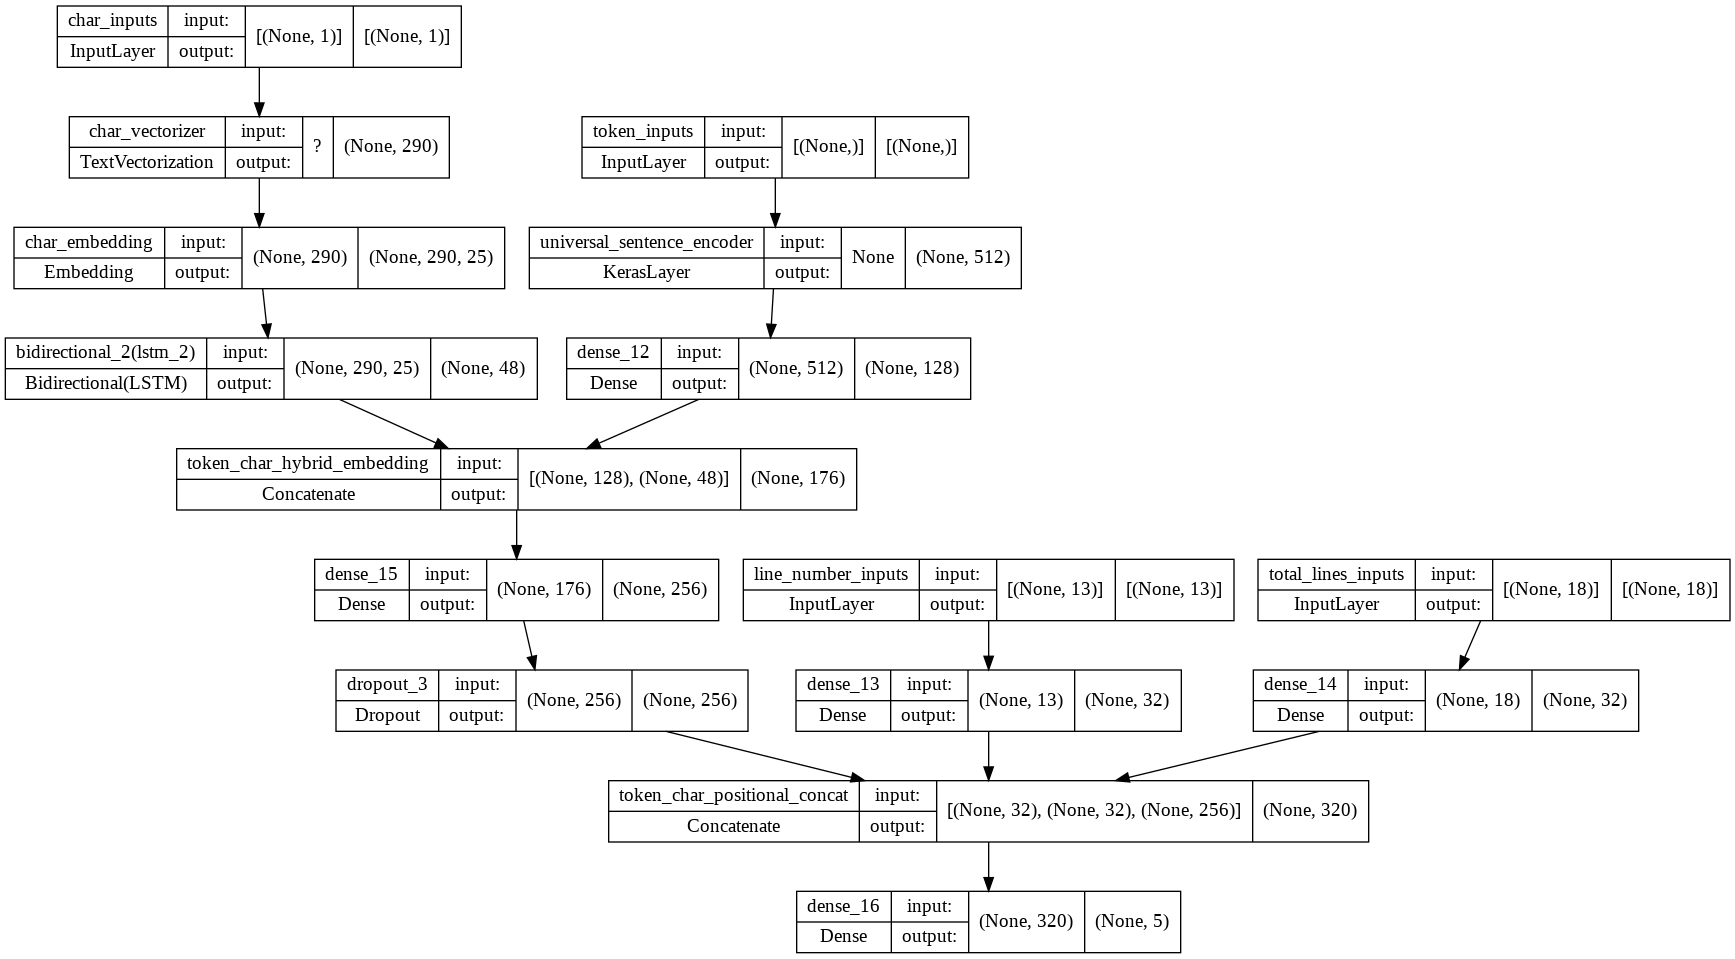

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Character level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(line_number_depth,), 
                                  dtype=tf.float32, 
                                  name="line_number_inputs")

x = layers.Dense(32, activation="relu")(line_number_inputs)

# Combine inputs and dense layer into a model
line_numbers_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)


# 4. total lines model
total_lines_inputs = layers.Input(shape=(total_lines_depth,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine line_numbers_model and total_line_model
tribrid_embeddings = layers.Concatenate(name="token_char_positional_concat")([line_numbers_model.output,
                                                                              total_lines_model.output,
                                                                              z])

# 7. Create an output layer to accept the tribried embedding and output label probabilities.
output_layer = layers.Dense(5, activation="softmax")(tribrid_embeddings)

# 8. Combine inputs of 1, 2, 3, 4, and outputs of into a `tf.keras.Model`
model_6 = tf.keras.Model(inputs=[token_model.input, char_model.input,
                                 line_numbers_model.input,
                                 total_lines_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")



plot_model(model_6, show_shapes=True)

In [ ]:
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/model_checkpoints",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
)



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3
)



In [ ]:
history_model_6 = model_6.fit(train_tribrid_dataset,
                              steps_per_epoch=len(train_tribrid_dataset),
                              validation_data=val_tribrid_dataset,
                              validation_steps=len(val_tribrid_dataset),
                              epochs=20,
                              callbacks=[model_checkpoint,
                                         early_stopping])

Epoch 1/20
5627/5627 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.8251

5627/5627 [==============================] - 267s 46ms/step - loss: 0.9516 - accuracy: 0.8251 - val_loss: 0.9059 - val_accuracy: 0.8526
Epoch 2/20
5627/5627 [==============================] - ETA: 0s - loss: 0.9079 - accuracy: 0.8557

5627/5627 [==============================] - 251s 45ms/step - loss: 0.9079 - accuracy: 0.8557 - val_loss: 0.8978 - val_accuracy: 0.8558
Epoch 3/20
5627/5627 [==============================] - ETA: 0s - loss: 0.8961 - accuracy: 0.8633

5627/5627 [==============================] - 250s 45ms/step - loss: 0.8961 - accuracy: 0.8633 - val_loss: 0.8961 - val_accuracy: 0.8570
Epoch 4/20
5627/5627 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.8696

5627/5627 [==============================] - 252s 45ms/step - loss: 0.8873 - accuracy: 0.8696 - val_loss: 0.8944 - val_accuracy: 0.8573
Epoch 5/20
5627/5627 [==============================] - ETA: 0s - loss: 0.8805 - accuracy: 0.8747

5627/5627 [==============================] - 252s 45ms/step - loss: 0.8805 - accuracy: 0.8747 - val_loss: 0.8942 - val_accuracy: 0.8580
Epoch 6/20
5627/5627 [==============================] - 219s 39ms/step - loss: 0.8749 - accuracy: 0.8787 - val_loss: 0.8959 - val_accuracy: 0.8574
Epoch 7/20
5627/5627 [==============================] - 219s 39ms/step - loss: 0.8703 - accuracy: 0.8828 - val_loss: 0.8960 - val_accuracy: 0.8570
Epoch 8/20
5627/5627 [==============================] - 218s 39ms/step - loss: 0.8654 - accuracy: 0.8861 - val_loss: 0.8976 - val_accuracy: 0.8562


In [ ]:
model_6_pred_probs = model_6.predict(test_tribrid_dataset)

In [ ]:
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

In [ ]:
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

### Use pretrained GloVe embeddings

Source: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-09-02 13:56:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-02 13:56:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-02 13:56:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

The archive contains text files for 100, 200, 300, and 50 dimension embedding vectors.

We will create a dictionary mapping of strings to their NumPy vector representation

In [ ]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.100d.txt"
)

In [ ]:
path_to_glove_file

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now we prepare a corresponding embedding matrix that we can use in Keras embedding layer. It's a simp NumPy matrix where entry at index i is the pretrained vector for the word of index 1 in our vectorizer0s vocabulary

In [ ]:
word_index = dict(zip(rct_20k_text_vocab, range(len(rct_20k_text_vocab))))


num_tokens = len(rct_20k_text_vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and for "OOV"
    embedding_matrix[i] = embedding_vector
    hits +=1
  else:
    misses+=1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 29730 words (35111 misses)


Next, we load the pretrained- word embeddings matrix into an Embedding layer. 
Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training)

In [ ]:
glove_embedding = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
)